In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator,QiskitRuntimeService
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import transpile
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
shots= 1024
sampler = Sampler(mode=backend)


We are using the aer_simulator quantum computer


In [80]:
n=3
iterations =  int((np.pi*np.sqrt(np.power(2,n)))//4)
Size= np.power(2,n)
print(f"Array Size: {Size}")
print(iterations)

Array Size: 8
2


In [ ]:
# Classical solution
db = [] # 2^n in size - we will randomly assign the elements to be 0 or 1
for i in range(Size):
    element= np.random.randint(0,2)
    db.append(element)
print(db)

solIndices = set([i for i, x in enumerate(db) if x == 1])

m = len(solIndices)

print(f"M = {m} and Indices of solutions = {solIndices}")

[1, 1, 1, 0, 0, 0, 0, 1]
M = 4 and Indices of solutions = [0, 1, 2, 7]


In [ ]:
def createGroverircuit(n, solution_indices, iter):
    
    groverQ = QuantumRegister(n, name='logical')
    groverCbit = ClassicalRegister(n, name='result')
    ancilla = QuantumRegister(2, name='anc')
    
    qc = QuantumCircuit(groverQ, ancilla, groverCbit)
    
    # Initialize to + state n qubits
    qc.h(groverQ)
    qc.barrier()
    
    for i in range(iter):
        
        for target_idx in solution_indices:
            
            target_binary = format(target_idx, f'0{n}b')
            # Prepare ancilla[0] |->
            qc.x(ancilla[0])
            qc.h(ancilla[0])

            for j in range(n):
                if target_binary[j] == '0':
                    qc.x(groverQ[n-j-1])  # Reverse order to match qubit ordering
            
            # Apply MCX
            qc.mcx(groverQ, ancilla[0])
            
            # Undo X gates
            for j in range(n):
                if target_binary[j] == '0':
                    qc.x(groverQ[n-j-1])
        
        # Reverse ancilla[0] to ground state
        qc.h(ancilla[0])
        qc.x(ancilla[0])
        qc.barrier(groverQ, ancilla[0])
        
        # Diffuser Step
        qc.h(groverQ)
        qc.barrier()
        
        # Prepare ancilla[1] |->
        qc.x(ancilla[1])
        qc.h(ancilla[1])
        
        # Apply Z0 GATE
        qc.x(groverQ)
        qc.mcx(groverQ, ancilla[1])
        qc.x(groverQ)
        
        # Reverse ancilla[1] to ground state
        qc.h(ancilla[1])
        qc.x(ancilla[1])
        qc.barrier()
        
        # Apply H gates again
        qc.h(groverQ)
        qc.barrier()
    
    qc.measure(groverQ, groverCbit)
    return qc

In [ ]:
def GAS(n, target_indices,T ):

    qc = createGroverircuit(n, target_indices, iter)
    transpiled_qc = transpile(qc)

    # job = sampler.run([transpiled_qc], shots=1024)  # Wrap circuit in a list
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    job = sampler.run(pm.run([transpiled_qc]),shots=shots)
    counts = job.result()[0].data.result.get_counts()
        
    return counts, qc

In [ ]:
def check_solution(result_counts,solIndices):
    threshold= 10

    for key, values in result_counts:
        if key in solIndices:
            
            valpercentage= (values/shots)*100

            if values<threshold    
    
    return True


Running Grover Adaptive Search with unknown number of solutions
Attempt 1, T = 1
Running with 1 iterations
{'111': 271, '000': 508, '001': 245}
Attempt 2, T = 2
Running with 1 iterations
{'001': 244, '000': 515, '111': 265}


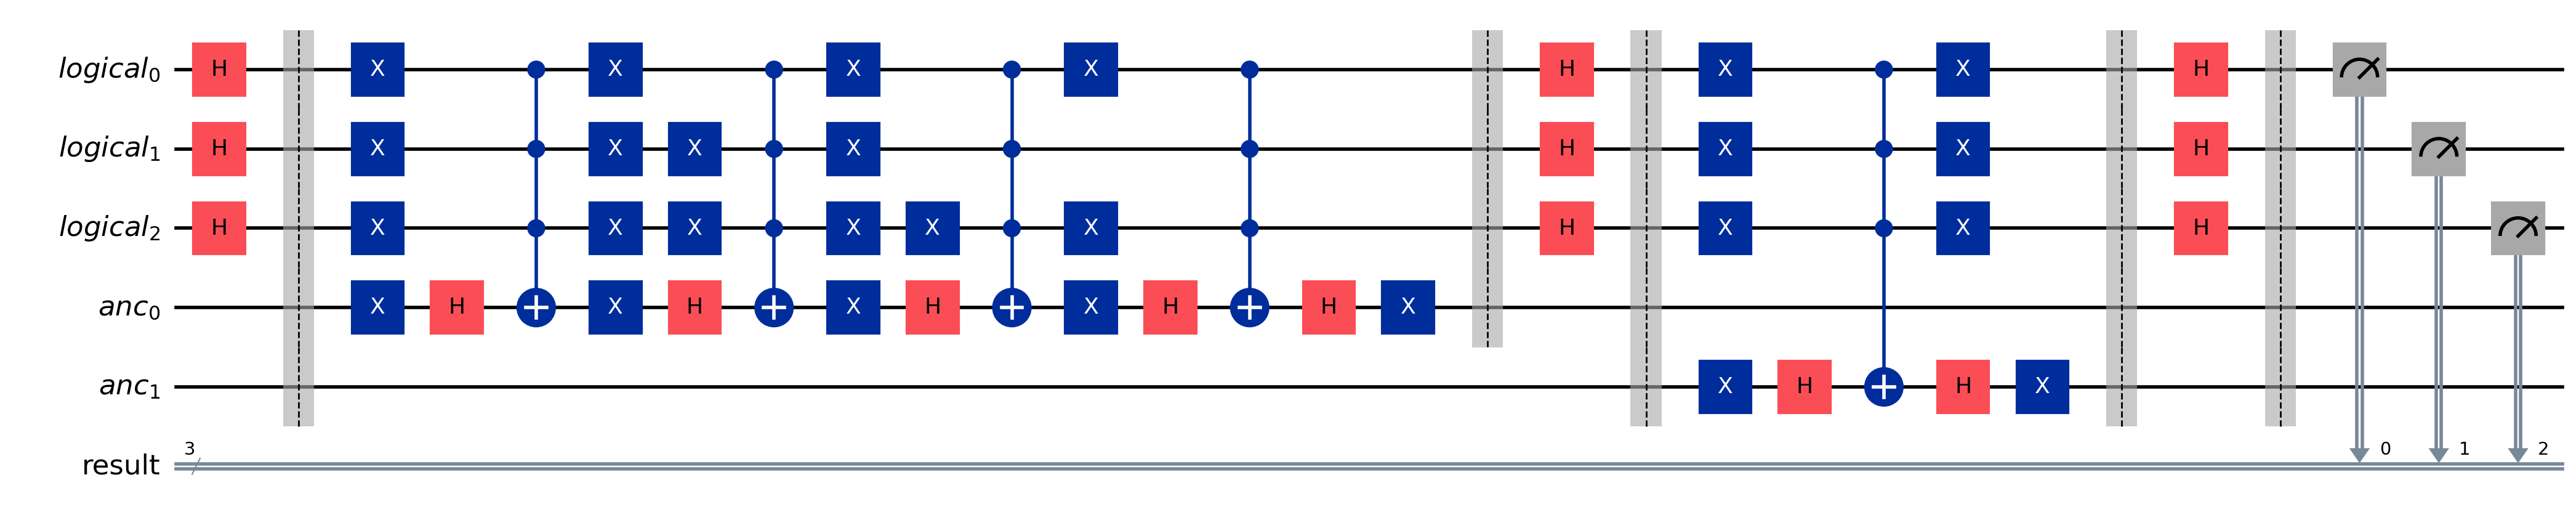

In [ ]:
# adaptive search
print("Running Grover Adaptive Search with unknown number of solutions")
T=1
for attempt in range(iterations):
    if T>iterations:
        break

    print(f"Attempt {attempt+1}, T = {T}")
        
    iter = np.random.randint(1, T+1)
    print(f"Running with {iter} iterations")
    result_counts, qc = GAS(n, solIndices,T,attempt)
  
    if check_solution(result_counts, solIndices):
        break

    T = int(np.ceil(1.25 * T))

print(result_counts)    
qc.draw('mpl', scale=2.0,fold=-1)



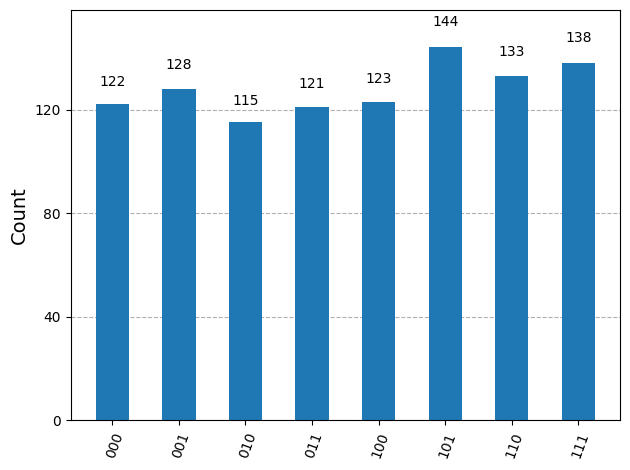

In [87]:
# fig = qc.draw('mpl', scale=2.0, fold=-1)
# fig.tight_layout()  
# fig.show()

plot_histogram(result_counts)